# <font color="#5fa8d3"> Claim Costs

## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation & Funtions Definition](#id0)<br>
1. [Syntetic Dataset](#id1)<br>
    1.1 [Miscellaneous Damage - lost parts (mis_lost)](#id11)<br>
    1.2 [Metal damage tear - torn (met_tear)](#id12)<br>
    1.3 [Metal damage scratches - paint scratches (met_scratch)](#id13)<br>
    1.4 [Glass damage crack - broken glass (glass_crack)](#id14)<br>
    1.5 [Miscellaneous Damage - puncture (mis_punct)](#id15)<br>
    1.6 [Miscellaneous Damage - broken lamp (mis_lamp)](#id16)<br>
    1.7 [Metal damage dent - minor dented (met_dent_minor)](#id17)<br>
    1.8 [Metal damage dent - medium dented (met_dent_medium)](#id18)<br>
    1.9 [Metal damage dent - severe dented (met_dent_severe)](#id19)<br>
    1.10 [Total Cost Dataset](#id110)<br>
2. [Cost Model](#id2)<br>

## <font color="#62b6cb"> 0. Libraries Importation & Funtions Definition <a name="id0"></a>

**Libraries Importation**

In [1]:
import json # to import jsons
import pandas as pd # to manipulate datasets
import numpy as np # to perform numerical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting nicer
from scipy.stats import gamma
import yaml # for importing a yaml file
from src.mymodule import * # for importing our functions

**Configuration Variables**

In [2]:
# Load the YAML file
with open('..\config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Function to set variables globally and store their names
def set_variables(config, prefix='', var_dict={}):
    for key, value in config.items():
        if isinstance(value, dict):
            set_variables(value, prefix + key + '_', var_dict)
        else:
            globals()[prefix + key] = value
            var_dict[prefix + key] = value
    return var_dict

# Set variables globally and get a dictionary of the set variables
set_vars = set_variables(config)

# Print all the variables that were set
print("Variables set from YAML file:")
for var_name, var_value in set_vars.items():
    print(f"{var_name}: {var_value}")

Variables set from YAML file:
seed: 123


We set the seed for reproducibility

In [3]:
np.random.seed(seed)

## <font color="#62b6cb"> 1. Synthetic Dataset <a name="id1"></a>

First we check again the claim classes that exist:

In [4]:
count_category_occurrences('../archive/image/image/annotations.json')

{'mis_lost': 2370,
 'met_tear': 4546,
 'met_dent': 4709,
 'met_scratch': 12267,
 'glass_crack': 1824,
 'mis_punct': 2006,
 'mis_lamp': 2324}

**Classes explanation**

* mat_bo_phan=lost parts (Miscellaneous Damage)
* rach=torn (Metal damage tear)
* mop_lom=dented (Metal damage dent)
* tray_son=paint scratches (Metal damage scratches)
* thung=puncture (Miscellaneous Damage)
* vo_kinh=broken glass (Glass damage crack)
* be_den= broken lamp (Miscellaneous Damage)

**New Classes explanation**

* mis_lost = lost parts (Miscellaneous Damage)
* met_tear = torn (Metal damage tear)
* met_scratch = paint scratches (Metal damage scratches)
* glass_crack = broken glass (Glass damage crack)
* mis_punct = puncture (Miscellaneous Damage)
* mis_lamp = broken lamp (Miscellaneous Damage)
* met_dent_minor = dented (Metal damage dent) - minor damage
* met_dent_medium = dented (Metal damage dent) - medium damage
* met_dent_severe = dented (Metal damage dent) - severe damage

**Synthetic dataset for Repair Cost**

To do this synthetic dataset we will just focus on the top 2 most popular car brands currently in Ireland by this [webpage](https://www.cso.ie/en/releasesandpublications/ep/p-ieu50/irelandandtheeuat50/society/carmakes/): Toyota and Volkswagen.

Besides to simplify it we will take just the main top 3 sales car models (not considering electric cars) of each one assuming that for each one the  repair cost distribution would change based on price of the model. 

For Toyota the [top3](https://www.toyota.ie/company/news/2023/irelands-best-selling-car-brand) models will be (ordered from [cheaper to more expensive](https://www.toyota.ie/)): Yaris (25k), Corolla (34k) and C-HR(41k). Therefore, Yaris a 25% cheaper and C-HR a 20% more expensive than Corolla.

For Volkswagen the [top3](https://www.cartell.ie/2022/06/most-popular-cars-in-ireland-in-2022/) models will be (ordered [from cheaper to more expensive](https://www.volkswagen.ie/en/new-cars.html)): Polo (24k), Golf (33k) and Tiguan (48k).  Therefore, Polo a 27% cheaper and Tiguan a 45% more expensive than Golf.

In general Toyota cars are [cheaper](https://caredge.com/ranks/maintenance) to repair than Volkswagen for car models of the same class as it is estimated that in 10 year maintenance cost it will be 6k vs 8k so a 25% cheaper.

Lastly we will consider the that cars have 3 different car age ranges. As the average age is [9 years](https://www.simi.ie/en/environment/drive-greener/national-vehicle-fleet) we will assume the following ranges: Newer vehicles [0 years to 7 years], middle age vehicles [7 years to 10 years] and old vehicles [more than 10 years].

The repair total costs usually increases over time at an average rate in [doubling](https://www.oponeo.co.uk/blog/how-expensive-are-car-repairs-over-time) every 5 years. However, this is so because even if the repair cost decreases over time, the frequency of the repair increases. As such, as here we are considering just the severity we can assume that they reduce over time. As we haven't found any webpage referring to the severity of the costs due to the vehicle age (new cars have pieces more sophisticated that are not so commonly fabricated and thus, they are more expensive) we will assume that in general they reduce by half in each of the 3 vehicle age ranges.

As such, we will create $2 \times 3 \times 3 \times 7 = 126$ different repair cost model.

**Synthetic dataset for Labour Cost**

It will be modeled in the following way:

$$\text{labour cost by hour} \times \text{nº of hours}$$

To do this synthetic dataset on the labour cost we will start off the claims generated synthetically from the repair cost. For each of them we will look at the damage type (lost parts...) and calculate the *nº of hours* based on that. The nº of hours will be modelled as an exponential distribution and the parameter $\lambda$ depends on the damage type.

On the other hand, the labour cost by hour will be based on the following:
+ *Fixed labor cost per hour*: that usually charge workshops in Ireland. As per the following 2 websites the average will be around €60 assuming it is not an official dealer workshop [webpage1](https://www.motorcheck.ie/blog/when-is-a-mechanic-not-a-mechanic/#:~:text=What%20are%20the%20individual%20charges,'%20or%20'Original%20Equipment) [webpage2](https://www.irishtimes.com/life-and-style/motors/why-do-car-dealers-charge-bank-manager-fees-to-service-your-vehicle-1.4507738)
+ *Type of workshop*: The Fixed labor cost per hour value would be multiplied with a factor that depends on 3 different types of workshops depending on their quality. 
    + low (factor 0.7 considering some cheap garages some people mention on the internet of about €40), medium (factor 1) and high (factor 1.7 considering official dealers workshops that as per the previous webpages are between €125 and €80).
    + Their probability distribution could be: 30%, 50% and 20% to consider that most customers don't repair in official workshops.
+ *County*: The Fixed labor cost per hour value would be multiplied with a factor that would consider the workshop location in terms of county to not make it too granular
    + The factors will be calculated assuming a ratio of the average salary per county over the Irish average [salary](https://www.cso.ie/en/releasesandpublications/ep/p-dea/distributionofearningsbygenderandcounty2022/distributionofearningsbycounty/#:~:text=Dublin%20had%20the%20highest%20median%20annual%20earnings%20in%202022%20at,the%20State%20at%20%E2%82%AC41%2C823) that is €41,736.
    + Their probability distribution would be based on the proportion of the county population over the total country [population](http://homepage.tinet.ie/~cronews/geog/census/copop.html).



In [5]:
# we define the labour costs variables

# average global labour cost per hour
av_lab_ph = 60

# workshop quality distribution and factors
workshop_qlty_factor = {"Low": 0.7,"Medium": 1,"High": 1.7}
workshop_qlty_dist = {"Low": 0.3,"Medium": 0.5,"High": 0.2}


# we create a table with the Irish counties real population proportions and their salary
Ireland_av_salary = 41736

data = [
        ('Dublin', 28.7, 46138),
        ('Cork', 11.4, 42766),
        ('Galway', 5.3, 40974),
        ('Limerick', 4.5, 40721),
        ('Kildare', 4.2, 45179),
        ('Tipperary', 3.6, 37961),
        ('Donegal', 3.5, 33526),
        ('Meath', 3.4, 43563),
        ('Kerry', 3.4, 36309),
        ('Mayo', 3, 37750),
        ('Wexford', 3, 36471),
        ('Wicklow', 2.9, 43140),
        ('Clare', 2.6, 40663),
        ('Louth', 2.6, 38686),
        ('Waterford', 2.6, 39439),
        ('Kilkenny', 2.1, 40024),
        ('Westmeath', 1.8, 40079),
        ('Offaly', 1.6, 38238),
        ('Laois', 1.5, 40307),
        ('Sligo', 1.5, 39444),
        ('Cavan', 1.4, 37236),
        ('Roscommon', 1.4, 39060),
        ('Monaghan', 1.3, 34718),
        ('Carlow', 1.2, 37809),
        ('Longford', 0.8, 36180),
        ('Leitrim', 0.7, 37715)
]

# we calculate the factors of the counties
county_info = pd.DataFrame(data, columns=['County', 'prob_dist','salary'])
county_info["factor"] = np.round(county_info.salary/Ireland_av_salary,1)
county_info.drop('salary', axis=1, inplace=True)

# we check the distribution of the factor variable

print(county_info.factor.describe().to_frame().round(2).T)

        count  mean   std  min  25%  50%  75%  max
factor   26.0  0.94  0.08  0.8  0.9  0.9  1.0  1.1


### <font color="#62b6cb">1.1 Miscellaneous Damage - lost parts (mis_lost)</font> <a name="id11"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.2 Metal damage tear - torn (met_tear)]</font> <a name="id12"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.3 Metal damage scratches - paint scratches (met_scratch)</font> <a name="id13"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.4 Glass damage crack - broken glass (glass_crack)</font> <a name="id14"></a>

**Repair Cost**

In [6]:
brands = {"Toyota": 1,"Volkswagen":1.25}

models = {"Yaris": 0.75, 
          "Corolla": 1, 
          "C-HR": 1.20,
          "Polo":0.73,
          "Golf":1,
          "Tiguan":1.45}

age_range={"Newer":0.8,"Middle":1,"Old":0.5}

df_repair_glass_crack = simulate_data(n=5000, damage_type="glass_crack",low_trunc=100,high_trunc=400,
                            brands=brands, models=models,
                            age_range={"Newer":0.8,"Middle":1,"Old":0.5},
                            model_effect=1.4,age_effect=0.7)
df_repair_glass_crack.shape

(90000, 6)

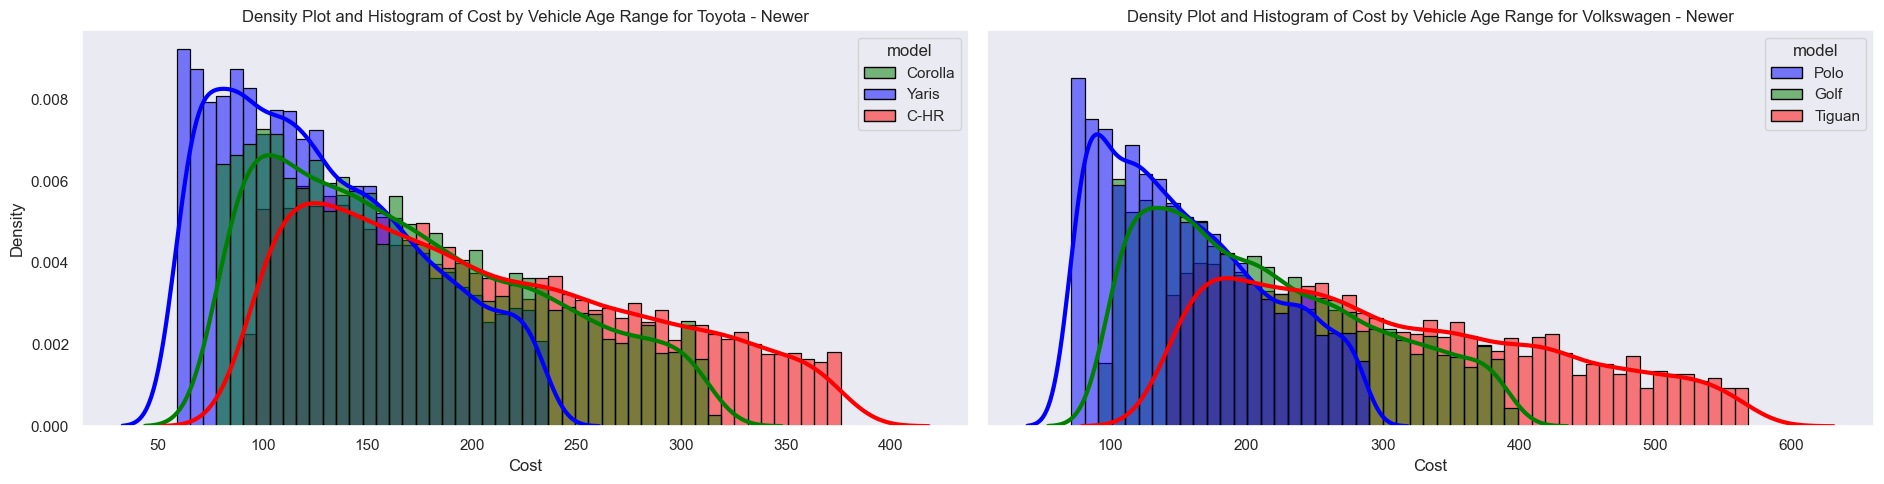

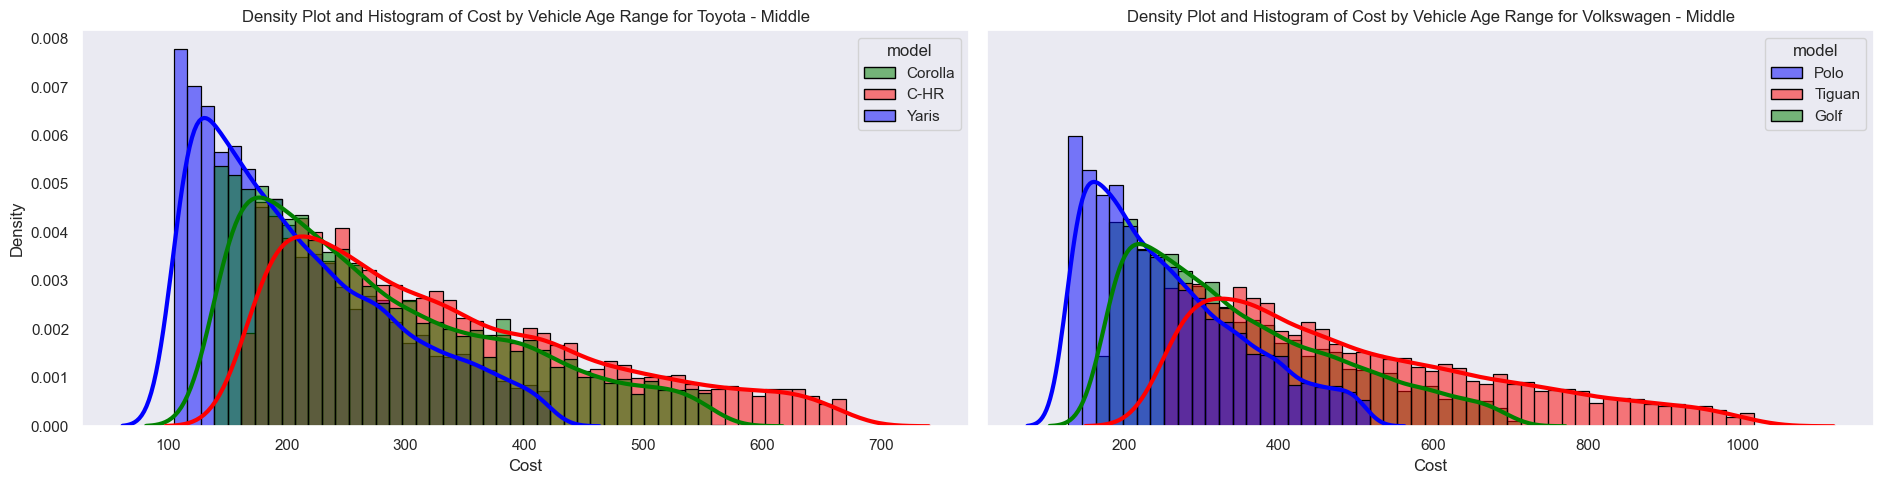

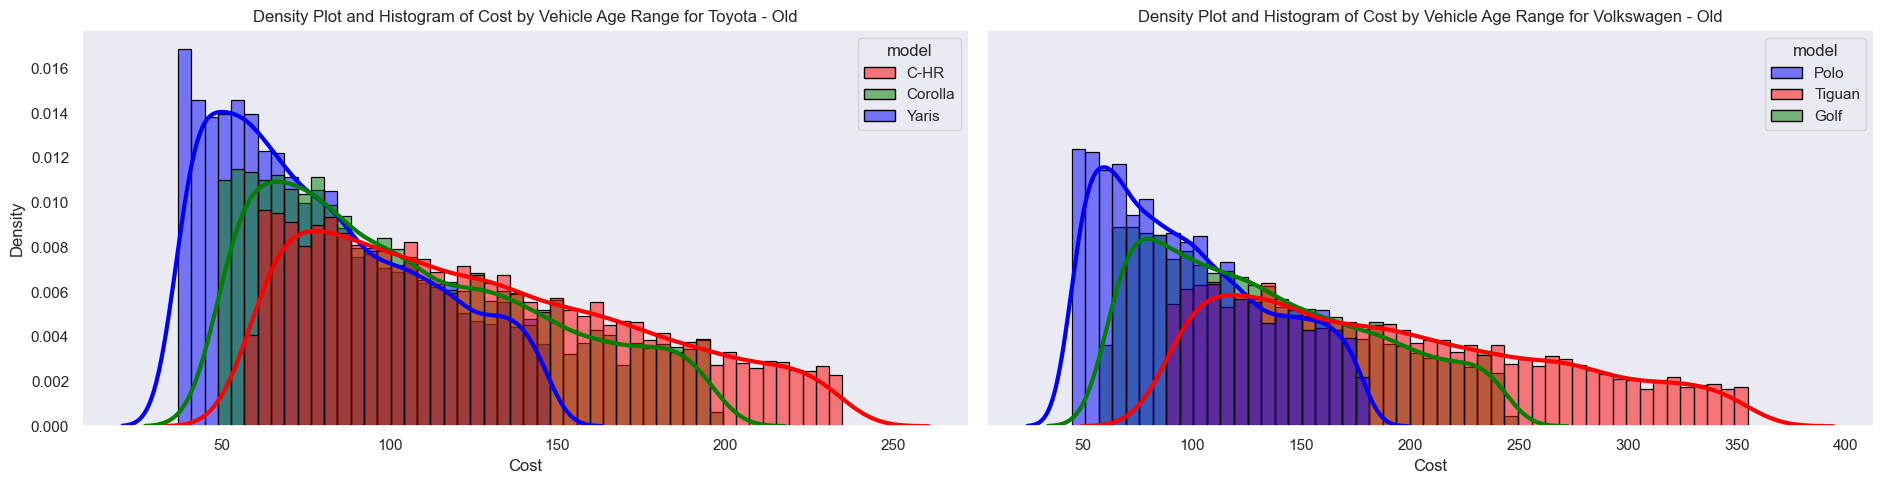

Summary statistics by brand, model, and vehicle age range:
                                  mean  std  min  25%  50%  75%   max
brand      model   veh_age_range                                     
Toyota     Yaris   Newer           128   47   59   88  120  162   235
                   Middle          207   79  105  140  188  259   420
                   Old              79   30   37   54   74  102   147
           Corolla Newer           169   63   78  115  159  217   314
                   Middle          277  107  140  188  250  351   559
                   Old             105   40   49   71   98  135   196
           C-HR    Newer           205   77   94  138  191  263   376
                   Middle          333  128  168  227  302  415   671
                   Old             127   47   59   86  119  162   235
Volkswagen Polo    Newer           155   59   72  104  145  198   286
                   Middle          253   97  128  173  231  315   510
                   Old         

In [7]:
cost_analysis(df_repair_glass_crack, models)

**Labour Cost**

To decide how much time it should take to repart a windscreen we are basing it on the following [source](https://www.autoglass.ie/top-5-myths-windscreen-repair/#:~:text=Repairs%20can%20take%20as%20little,repair%20misconceptions%20laid%20to%20rest.). As such, from 0.5 to 2 hours.

                      count   mean    std   min    25%    50%    75%     max
num_hours           90000.0   0.64   0.14   0.5   0.54   0.60   0.70    2.01
labour_costs        90000.0  62.75  21.70  33.6  46.20  60.00  66.00  112.20
total_labour_costs  90000.0  40.34  16.91  16.8  28.62  35.42  48.57  201.22


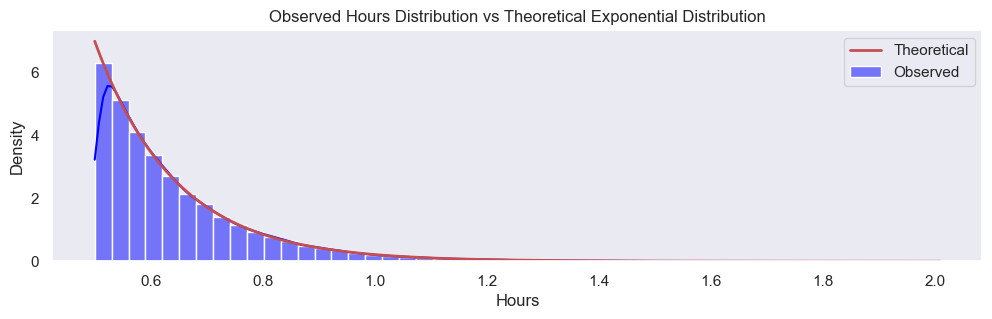

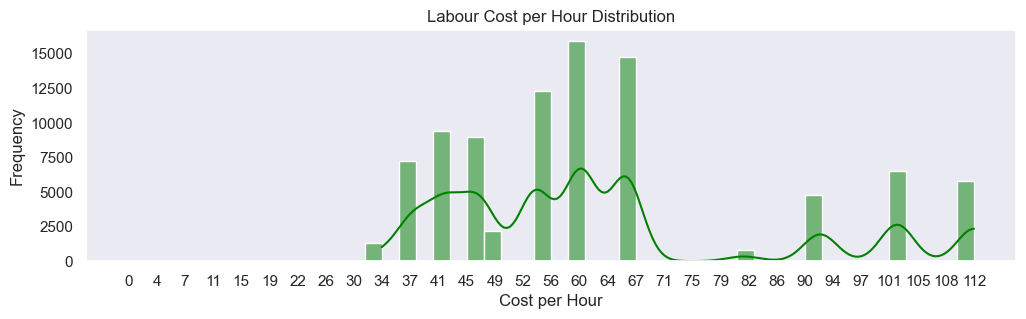

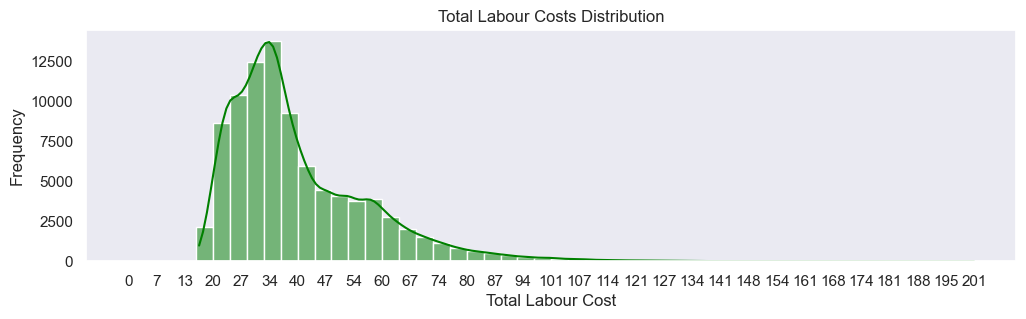

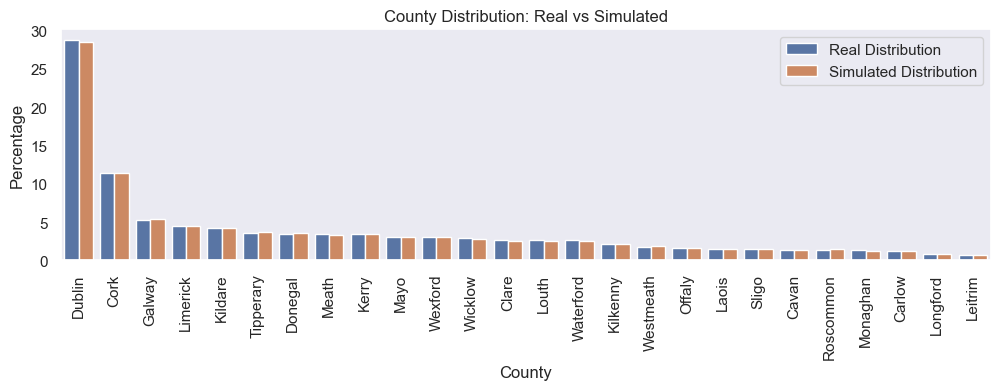

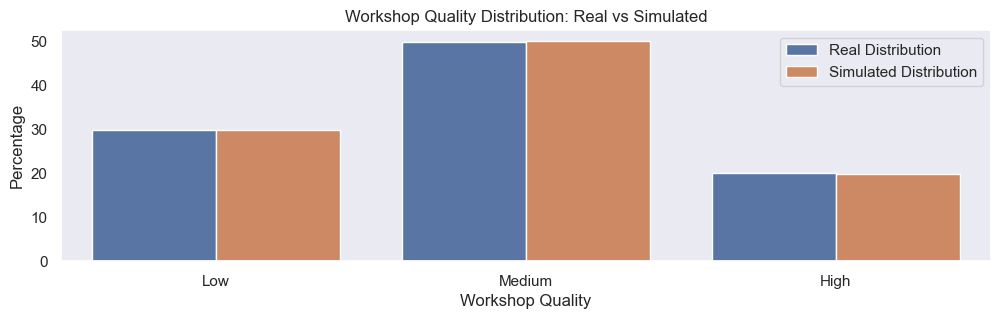

In [8]:
lmbda=7
df_labour_glass_crack = simulate_labour(n=90000, lmbda=lmbda,ini=0.5,
                                        workshop_qlty_factor=workshop_qlty_factor,
                                        workshop_qlty_dist=workshop_qlty_dist, 
                                        county_info=county_info,
                                        av_lab_ph=av_lab_ph)

labour_analysis(df_labour_glass_crack,lmbda=lmbda,ini=0.5,workshop_qlty_dist=workshop_qlty_dist)

**Total Cost**

In [9]:
df_total_glass_crack = conc_total_cost(df_repair_glass_crack, df_labour_glass_crack)
print(df_total_glass_crack.head())

        brand    model veh_age_range workshop_quality   counties  damage_type  \
0  Volkswagen     Polo         Newer             High     Carlow  glass_crack   
1      Toyota     C-HR           Old              Low  Tipperary  glass_crack   
2      Toyota  Corolla        Middle             High   Longford  glass_crack   
3  Volkswagen     Polo        Middle           Medium     Carlow  glass_crack   
4  Volkswagen     Golf         Newer             High   Kilkenny  glass_crack   

   repair_cost  labour_cost  total_cost  
0       197.22        95.13      292.35  
1       124.22        20.27      144.49  
2       163.60        54.65      218.25  
3       194.94        29.19      224.13  
4       103.56        64.95      168.51  


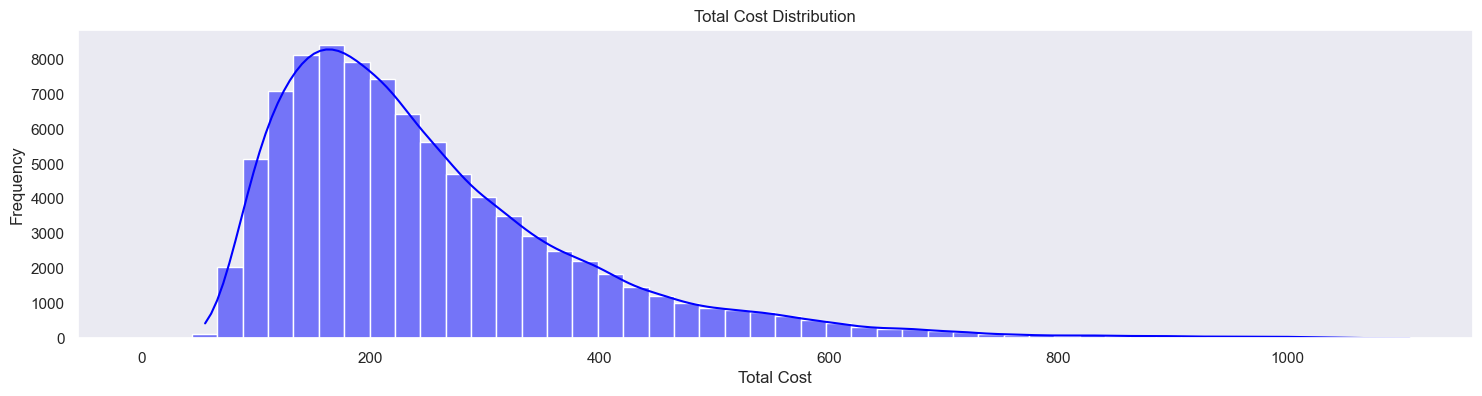

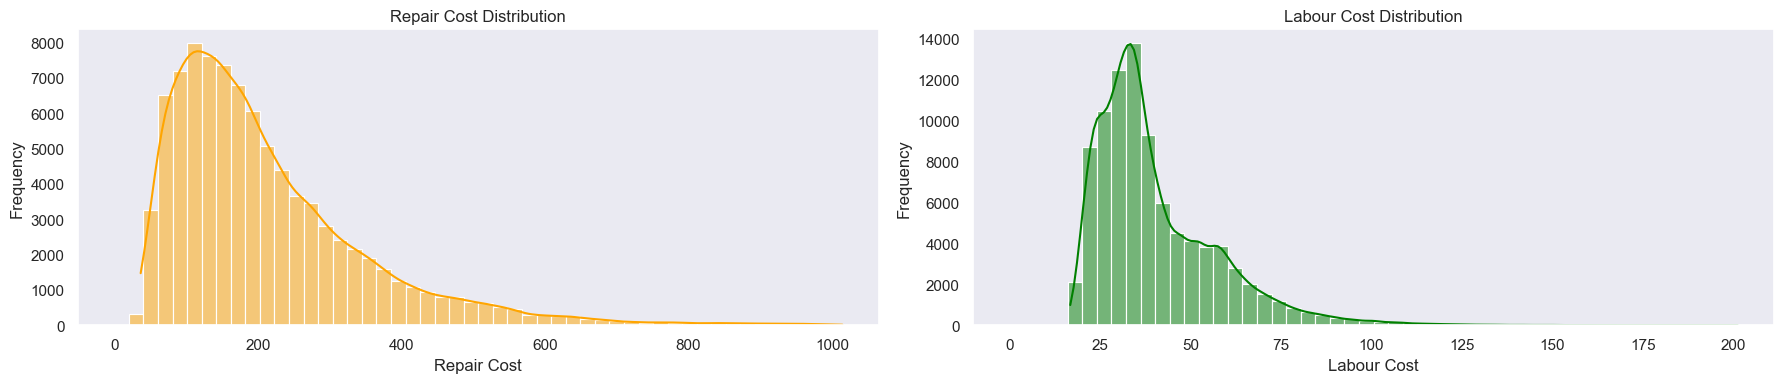

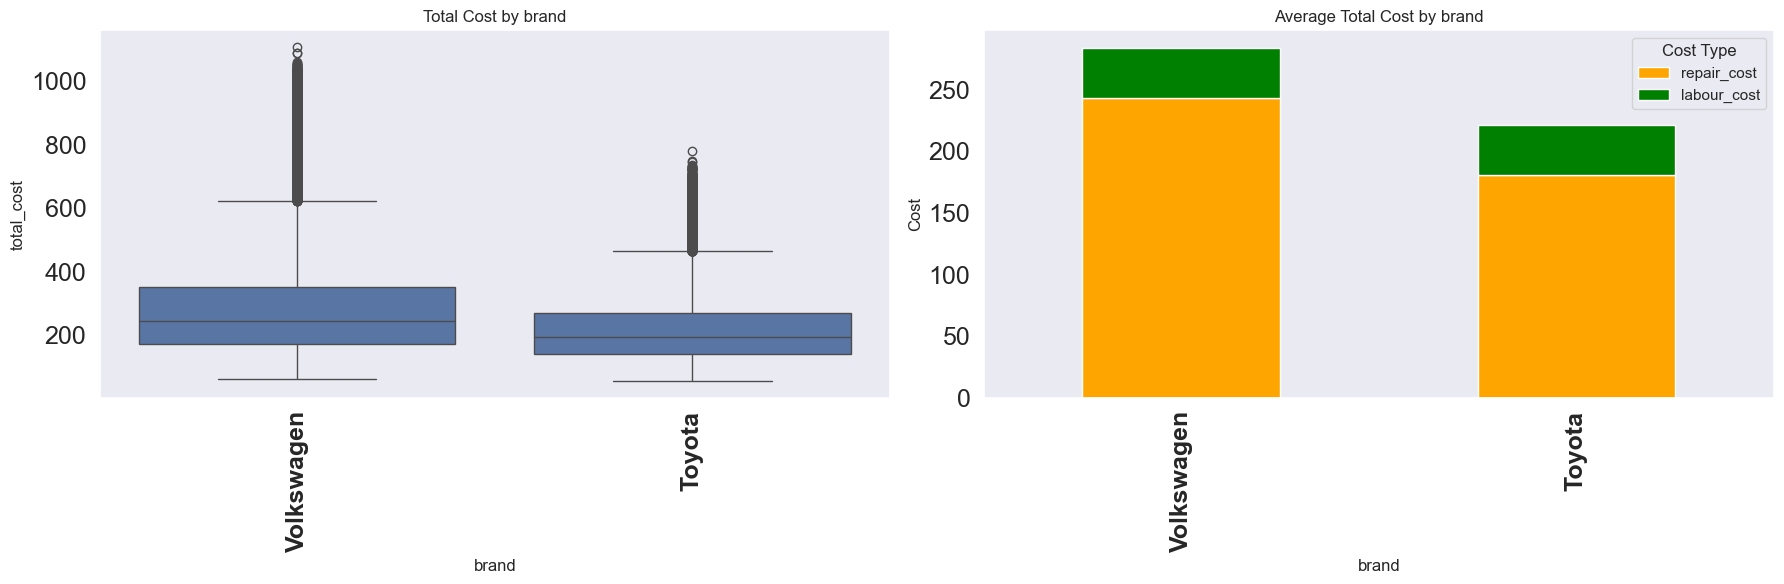

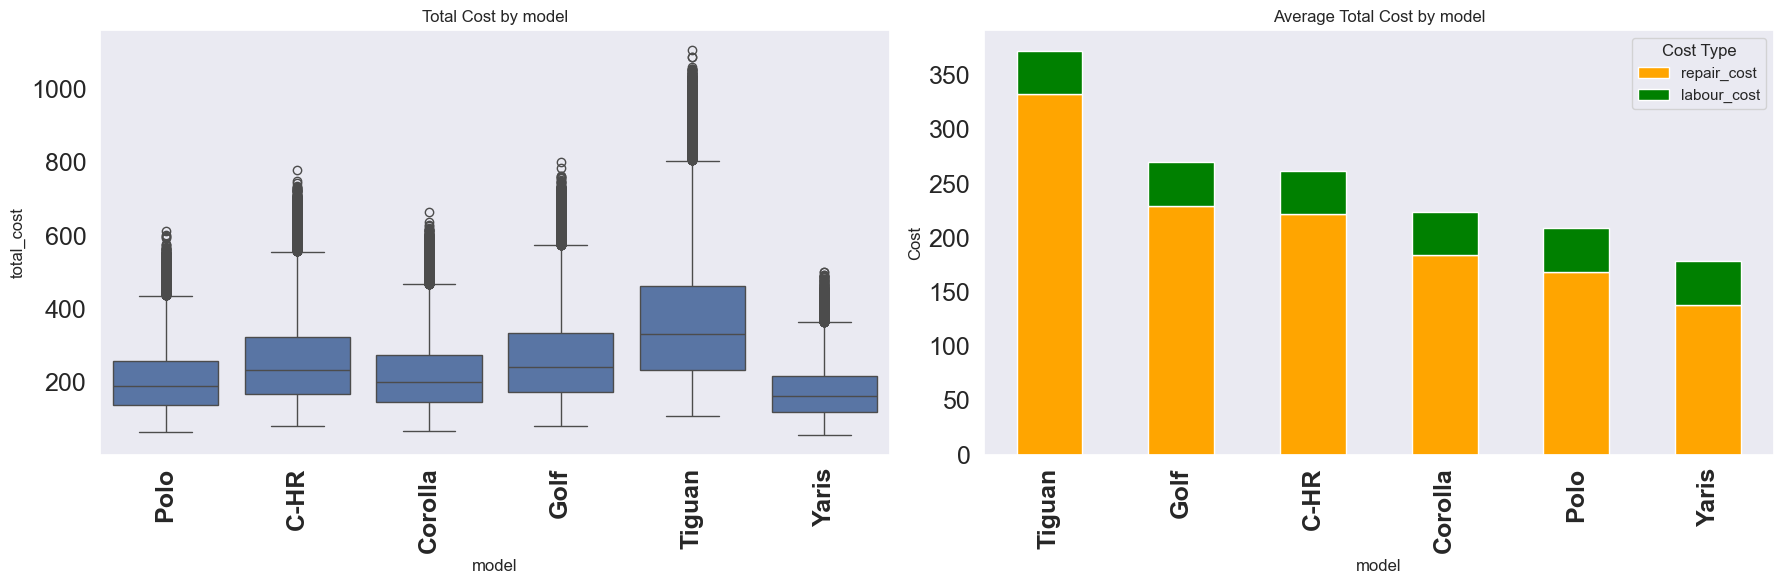

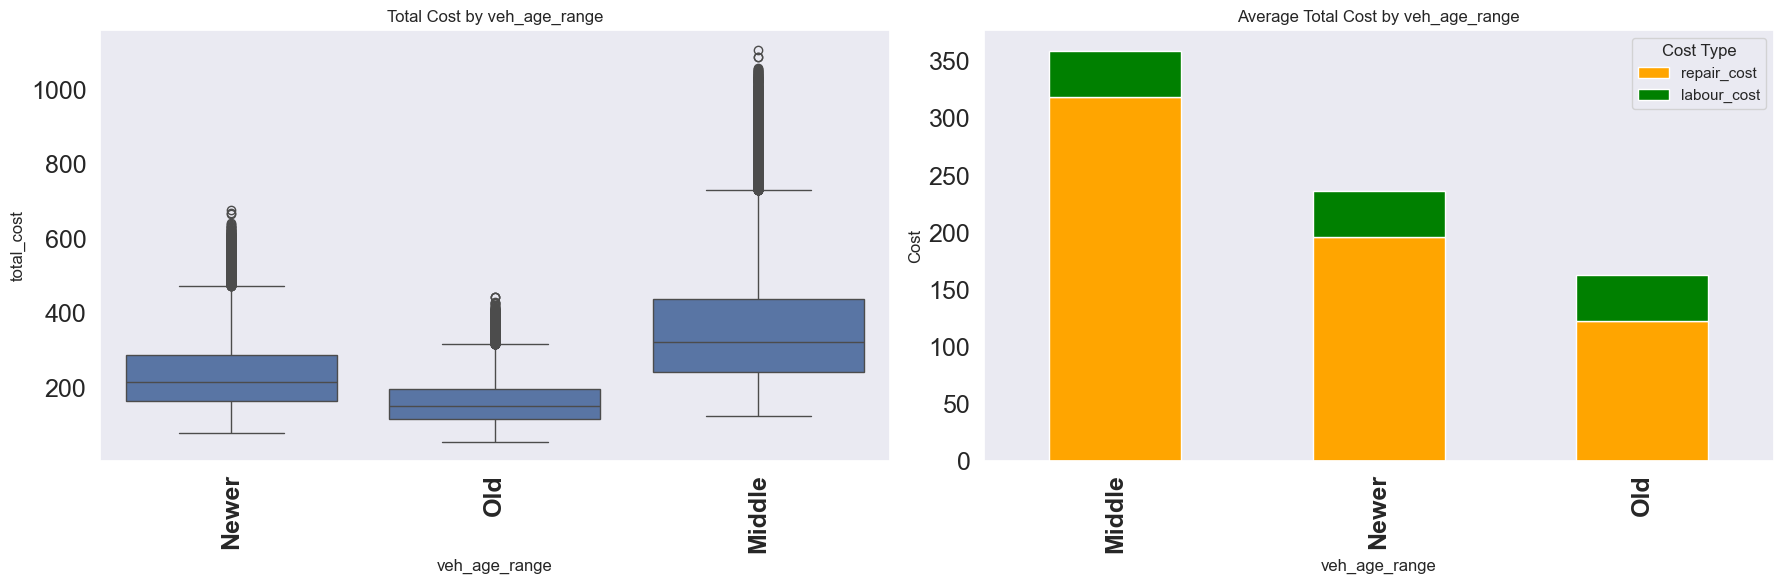

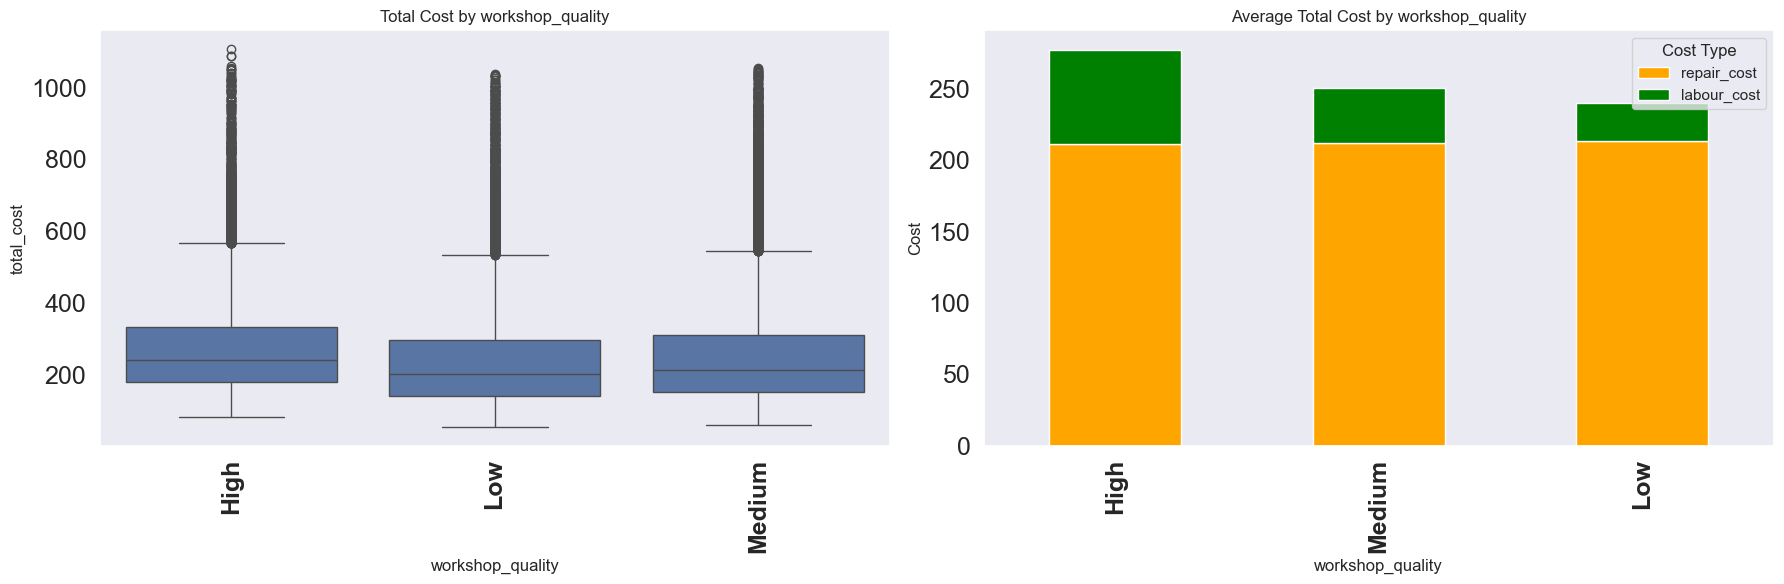

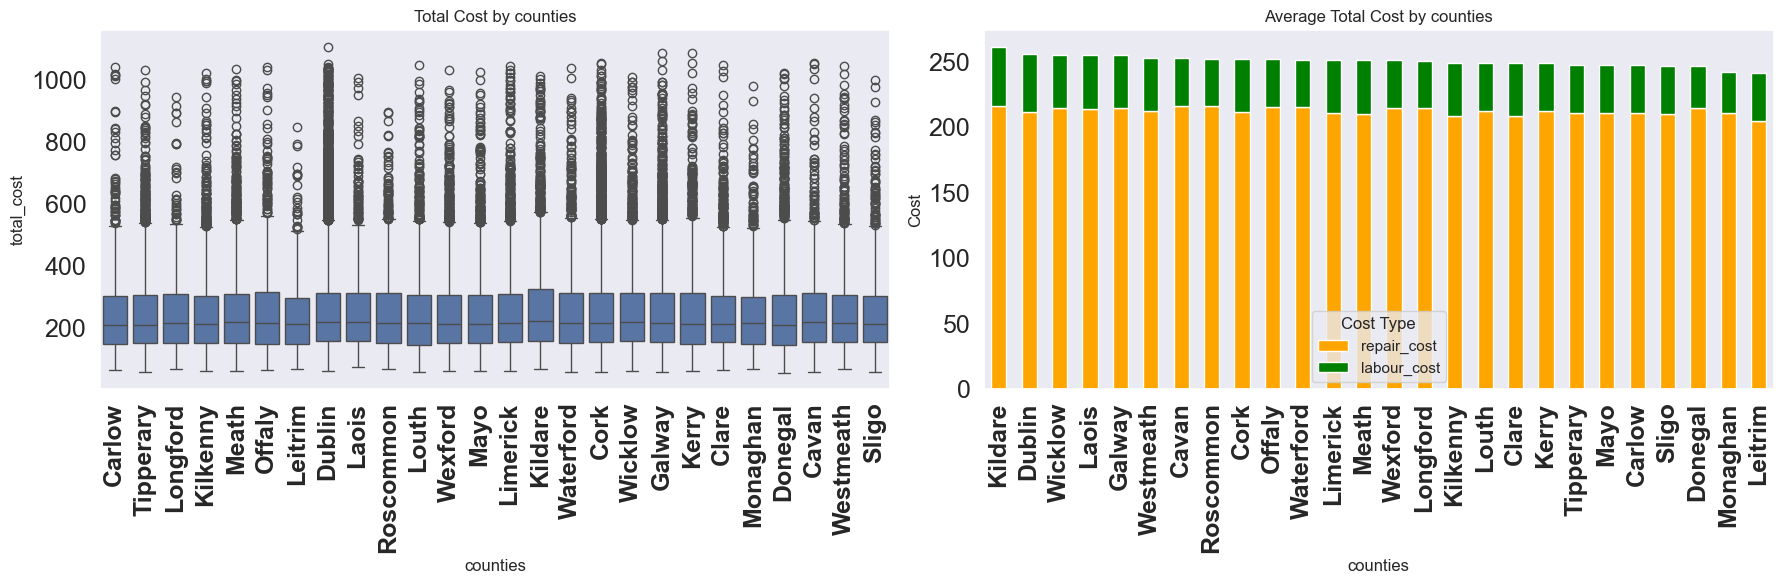

In [10]:
analysis_total_cost(df_total_glass_crack)

### <font color="#62b6cb">1.5 Miscellaneous Damage - puncture (mis_punct)</font> <a name="id15"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.6 Miscellaneous Damage - broken lamp (mis_lamp)</font> <a name="id16"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.7 Metal damage dent - minor dented (met_dent_minor)</font> <a name="id17"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.8 Metal damage dent - medium dented (met_dent_medium)</font> <a name="id18"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

### <font color="#62b6cb">1.9 Metal damage dent - severe dented (met_dent_severe)</font> <a name="id19"></a>

**Repair Cost**

**Labour Cost**

**Total Cost**

For defining the repairs costs distribution of this damage type, we have looked into the following webpages:
* [airtasker](https://www.airtasker.com/ie/costs/windscreen-repair-replacement/cost-of-windscreen-repairs-and-replacement/)

It states that in general prices go from €100 to €380 with a median of €200.

### <font color="#62b6cb">1.10 Total Cost Dataset</font> <a name="id110"></a>

## <font color="#62b6cb"> 2. Cost Model <a name="id2"></a>

+ Take the database a shuffle the observations using 123 seed 
+ Split Train and test
+ lasso regression or ridge regression?
+ gamma link function as it is and average cost model?
+ no splines because they are categorical variables?
+ for counties check the absolute value of training observations for and the average cost - chart of how it is distributed
+ Take all the variables because we know all of them are relevant
+ get the MSE but also the Emblem backtesting calculation
+ look again how to save the model and store it and in another one run it
